In [4]:
import argparse
import os
import math
import numpy as np
import SimpleITK as sitk
import random
import pandas as pd
from typing import Tuple, Dict

import torch
from torch import Tensor
import torch.optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms

from monai.transforms import (
    Compose,
    Resize,
    RandRotate,
    Affine,
    RandGaussianNoise,
    RandZoom,
    RepeatChannel,
)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import joblib
import h5py
import openpyxl
from openpyxl import Workbook
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
wb=openpyxl.load_workbook("../duke/Clinical_and_Other_Features.xlsx")
sheets=wb.sheetnames
interestSheet=wb[sheets[0]]

In [3]:
interestSheet['AM5'].value

0

In [52]:
wb.close()

### Below implementation turned out to be flawed -- images could be flipped along axis 

In [53]:
wb=openpyxl.load_workbook("../duke/Clinical_and_Other_Features.xlsx")
sheets=wb.sheetnames
interestSheet=wb[sheets[0]]

patientLRflag=dict() #{f'Breast_MRI_{i}':{'L':0,'R':1}}
patientNoBilat=set()

for i in range(4,interestSheet.max_row+1):
    if type(interestSheet[f"A{i}"].value) == str is not None and "breast_mri_" in interestSheet[f"A{i}"].value.lower():
        if interestSheet[f"AM{i}"].value==0:
            patientNoBilat.add(str(int(interestSheet[f"A{i}"].value.split("_")[-1])))

    if type(interestSheet[f"A{i}"].value) == str is not None and "breast_mri_" in interestSheet[f"A{i}"].value.lower() and interestSheet[f"AM{i}"].value==0:
        if type(interestSheet[f"AK{i}"].value) == str and "L" in interestSheet[f"AK{i}"].value.upper() or "R" in interestSheet[f"AK{i}"].value.upper():
            #patientLRflag[interestSheet[f"A{i}"].value]=dict()
            if "L" in interestSheet[f"AK{i}"].value.upper():
                patientLRflag[interestSheet[f"A{i}"].value]={"L":1,"R":0} # 1 means cancer on left side
            else:
                patientLRflag[interestSheet[f"A{i}"].value]={"L":0,"R":1}


wb.close()

In [42]:
boundingBoxXL=openpyxl.load_workbook("../duke/Annotation_Boxes.xlsx")
interestSheet=boundingBoxXL[boundingBoxXL.sheetnames[0]] #B2:B start_row, C2:C end_row 

patientBoundBoxCol=dict()
for i in range(2,interestSheet.max_row+1):
    if type(interestSheet[f"A{i}"].value) == str is not None and "breast_mri_" in interestSheet[f"A{i}"].value.lower()\
    and type(interestSheet[f"D{i}"].value)==int and type(interestSheet[f"E{i}"].value)==int:
        patientBoundBoxCol[str(int(interestSheet[f"A{i}"].value.split("_")[-1]))]=(interestSheet[f"D{i}"].value,interestSheet[f"E{i}"].value)


boundingBoxXL.close()

In [43]:
patientBoundBoxCol['21'] #"Breast_MRI_021"

(73, 109)

In [35]:
patientLRflag["Breast_MRI_021"]

{'L': 1, 'R': 0}

1.0

In [ ]:
#check if bounding box is on left or right side (end col & start col > im.shape[2]//2

In [54]:
#we're assuming that the firstpass data is in the same orientation as the bounding boxes describe the MRI interest region

inputData='data/firstpass_923.h5'
outputFile='data/FP923_LRsplit.h5'
midOverlapKeys=set()

with h5py.File(f'{outputFile}','w') as patientData:
    with h5py.File(inputData, 'r') as f:
        LRkeys=set(f.keys()) & set(patientBoundBoxCol.keys()) & patientNoBilat
        
        # Iterate over the groups in the file
        for key in LRkeys:
            arr=f[key]['data'][:]
            midCol=arr.shape[2]//2
            if (patientBoundBoxCol[key][0]<midCol and patientBoundBoxCol[key][1]<midCol) or (patientBoundBoxCol[key][0]>midCol and patientBoundBoxCol[key][1]>midCol): #not in middle
                grp=patientData.create_group(key)
                #save each side
                imageL=arr[:,:,:midCol]
                imageR=arr[:,:,midCol:]
                imageL=(imageL-imageL.min())/(imageL.max()-imageL.min())
                imageR=(imageR-imageR.min())/(imageR.max()-imageR.min())
                grp.create_dataset('L',data=imageL,compression="gzip", compression_opts=6)
                grp.create_dataset('R',data=imageR,compression="gzip", compression_opts=6)
                ### check if L or R, then apply grp.attrs['LRflag']=[1,0] or [0,1]
                if (patientBoundBoxCol[key][0]<midCol and patientBoundBoxCol[key][1]<midCol):
                    grp.attrs['LRflag']=np.array([1,0])
                else:
                    grp.attrs['LRflag']=np.array([0,1])
            else:
                midOverlapKeys.add(key)

LRkeys=list(LRkeys-midOverlapKeys)
LRkeys.sort()








In [58]:
patientNoBilat-set(LRkeys)

{'1', '120', '279', '596', '65', '700', '704'}

In [55]:
len(LRkeys)

616

In [63]:
checkKeys=['18', '19', '20', '21', '25', '26', '29']
{str(i) for i in checkKeys}&set(LRkeys)
#downSamp by 3.2


{'18', '19', '20', '21', '25', '26', '29'}

In [67]:
boundBoxFinals=[]

inputData='data/FP923_LRsplit.h5'

lowerBound=.20
outputFile=f'data/FP923_LRsplit_crop_point{int(lowerBound*100)}Thresh.h5'

with h5py.File(f'{outputFile}','w') as patientData:
    with h5py.File(inputData, 'r') as f:
        for key in f.keys():
            grp=patientData.create_group(key)
            
            for subKey in ['L','R']:
                arr=f[key][subKey][:]
                xs,ys,zs = np.where(arr>lowerBound)  
                boundingBox=[[np.min(xs),np.max(xs)+1],[np.min(ys),np.max(ys)+1],[np.min(zs),np.max(zs)+1]]
                boundBoxFinals.append(boundingBox)
                result=arr[boundingBox[0][0]:boundingBox[0][1],boundingBox[1][0]:boundingBox[1][1],boundingBox[2][0]:boundingBox[2][1]]
                grp.create_dataset(subKey,data=result,compression="gzip", compression_opts=4)
            grp.attrs['LRflag']=f[key].attrs['LRflag']
                

In [68]:
##resize
boundBoxFinals=np.asarray(boundBoxFinals)
#boxDim=boundBoxFinals[:,1]-boundBoxFinals[:,0]
avgShape=boundBoxFinals.mean(axis=0)
imgSize=np.round(avgShape)
transform=Compose([Resize(spatial_size=imgSize)])
imgSize

array([[  5., 169.],
       [ 80., 403.],
       [  6., 237.]])

In [69]:
resizeAvg=imgSize[:,1]-imgSize[:,0]
resizeAvg

array([164., 323., 231.])

In [70]:
np.round(resizeAvg/3.2)

array([ 51., 101.,  72.])

In [71]:
### now let's resize the data and save to one final h5 file for the pipeline

##resize
imgSize=resizeAvg ## retrieved from first read block or rounded average of grp[shape]
imgSize=np.array([164., 323., 231.]) ## LR split avg
downSample=2
imgSize=np.round(imgSize/downSample)
transform=Compose([Resize(spatial_size=imgSize)])


checkKeys=['18', '19', '20', '21', '25', '26', '29']


lowerBound=.20
inputData=f'data/FP923_LRsplit_crop_point{int(lowerBound*100)}Thresh.h5'
outputFile=f'data/FP923_LR_avgCrop_DS{int(downSample*10)}_point{int(lowerBound*100)}Thresh_subSample.h5'

with h5py.File(f'{outputFile}','w') as patientData:
    with h5py.File(inputData, 'r') as f:
        for key in set(f.keys()) & set(checkKeys):
            grp=patientData.create_group(key)
            grp.attrs['LRflag']=f[key].attrs['LRflag']
            for subKey in ['L','R']:
                arr=f[key][subKey][:]
                volume=torch.tensor(arr).unsqueeze(0)
                volume=transform(volume)
                images=volume[0].numpy().astype(np.float16)
                images=(images-images.min())/(images.max()-images.min())
                grp.create_dataset(subKey,data=images,compression="gzip", compression_opts=6)




In [73]:
### now let's resize the data and save to one final h5 file for the pipeline

##resize
imgSize=resizeAvg ## retrieved from first read block or rounded average of grp[shape]
downSample=2.0
imgSize=np.round(imgSize/downSample)
transform=Compose([Resize(spatial_size=imgSize)])


checkKeys=['18', '19', '20', '21', '25', '26', '29']


lowerBound=.20
inputData=f'data/FP923_LRsplit_crop_point{int(lowerBound*100)}Thresh.h5'
outputFile=f'data/FP923_LR_avgCrop_DS{int(downSample*10)}_point{int(lowerBound*100)}Thresh.h5'

with h5py.File(f'{outputFile}','w') as patientData:
    with h5py.File(inputData, 'r') as f:
        for key in set(f.keys()):
            grp=patientData.create_group(key)
            grp.attrs['LRflag']=f[key].attrs['LRflag']
            for subKey in ['L','R']:
                arr=f[key][subKey][:]
                volume=torch.tensor(arr).unsqueeze(0)
                volume=transform(volume)
                images=volume[0].numpy().astype(np.float16)
                images=(images-images.min())/(images.max()-images.min())
                grp.create_dataset(subKey,data=images,compression="gzip", compression_opts=6)


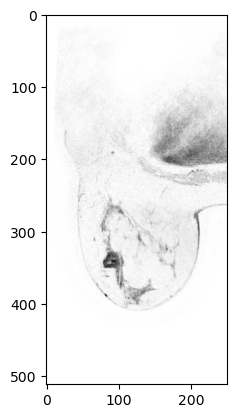

In [36]:
#slice 125/176
#row - 73:109 -1 
#col - 324:359 -1
colBox=[72,108]
rowBox=[323,358]

plt.imshow(arr[124,:,:250],cmap="Greys")

In [5]:
downSample=3.2
lowerBound=.2
inputData=f'data/FP923_LR_avgCrop_DS{int(downSample*10)}_point{int(lowerBound*100)}Thresh.h5'

#keys=[]

with h5py.File(inputData, 'r') as f:
    keys=[f"Breast_MRI_{k.zfill(3)}" for k in f.keys()]

keys.sort()


In [6]:
keys

['Breast_MRI_002',
 'Breast_MRI_004',
 'Breast_MRI_005',
 'Breast_MRI_007',
 'Breast_MRI_008',
 'Breast_MRI_009',
 'Breast_MRI_010',
 'Breast_MRI_012',
 'Breast_MRI_013',
 'Breast_MRI_014',
 'Breast_MRI_015',
 'Breast_MRI_017',
 'Breast_MRI_018',
 'Breast_MRI_019',
 'Breast_MRI_020',
 'Breast_MRI_021',
 'Breast_MRI_023',
 'Breast_MRI_024',
 'Breast_MRI_025',
 'Breast_MRI_026',
 'Breast_MRI_027',
 'Breast_MRI_028',
 'Breast_MRI_029',
 'Breast_MRI_031',
 'Breast_MRI_033',
 'Breast_MRI_036',
 'Breast_MRI_037',
 'Breast_MRI_038',
 'Breast_MRI_039',
 'Breast_MRI_041',
 'Breast_MRI_042',
 'Breast_MRI_044',
 'Breast_MRI_047',
 'Breast_MRI_048',
 'Breast_MRI_049',
 'Breast_MRI_051',
 'Breast_MRI_052',
 'Breast_MRI_053',
 'Breast_MRI_057',
 'Breast_MRI_058',
 'Breast_MRI_059',
 'Breast_MRI_061',
 'Breast_MRI_063',
 'Breast_MRI_064',
 'Breast_MRI_066',
 'Breast_MRI_067',
 'Breast_MRI_071',
 'Breast_MRI_073',
 'Breast_MRI_075',
 'Breast_MRI_076',
 'Breast_MRI_079',
 'Breast_MRI_080',
 'Breast_MRI

In [8]:
with open("nonBilateralPatients.txt","w") as f:
    for k in keys:
        f.write(f"{k},\n")
